# 基于 GoogLeNet 的 CIFAR-10 数据集的分类
## GoogLeNet 
### Inception 块
其基本架构如下图：
![](/figures/inception.png)

输入后有四个通道：
1.  $1 \times 1$ 卷积
2.  $1 \times 1$ 卷积 + $3 \times 3$ 卷积，填充为1
3.  $1 \times 1$ 卷积 + $5 \times 5$ 卷积，填充为2
4.  $3 \times 3$ 最大池化，填充为 1 + $1 \times 1$ 卷积

输入输出的高宽保持不变，通过改变各个通道的输入通道数来降低模型复杂度。使用 Inception 比直接使用卷积块，参数更少，计算效率更高。

### GoogLeNet 基本框架
输入：图片（$3\times 224\times 224$）

1. 
- $7\times 7$ 卷积层（64），步幅为 2，填充为 3
- $3\times 3$ 最大汇聚层，步幅为 2，填充为 1
2. 
- $1\times 1$ 卷积层（64）
- $3\times 3$ 卷积层（192），填充为 1
- $3\times 3$ 最大汇聚层，步幅为 2，填充为 1

输出：$192\times 28\times 28$

3. 
- 2 个 Inception 块（内部没有太多明显规律）:
- 块1：64
- 块2：96+128
- 块3: 16+32
- 块4: 32
通道数合计：256
- 块1: 128
- 块2：128+192
- 块3: 32+96
- 块4: 64
通道数合计：480
- $3\times 3$ 最大汇聚层，步幅为 2，填充为 1

输出：$480\times 14\times 14$

4. 
- 5 个Inception 块:
- $3\times 3$ 最大汇聚层，步幅为 2，填充为 1

5. 
- 2 个 Inception 块
- 全局平均汇聚层


- 全连接层

输出：10 个类别样本

In [4]:
# imports
from torch import optim
import basic
import torch
from torch import nn
from torch.nn import functional as F

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2 = nn.Conv2d(in_channels,c4,kernel_size=1)

    def forward(self,x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1,p2,p3,p4), dim=1)

class GoogLeNet(basic.Net):
    def __init__(self):
        super(basic.Net).__init__()
        self.GoogLeNet()
    
    def GoogLeNet(self):
        b1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        b2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64,192,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

        b3 = nn.Sequential(
            Inception(192,64,(96,128),(16,32),32),
            Inception(256,128,(128,192),(32,96),64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
        
        self.net = nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

Files already downloaded and verified
Files already downloaded and verified
['cat', 'frog', 'frog', 'airplane']


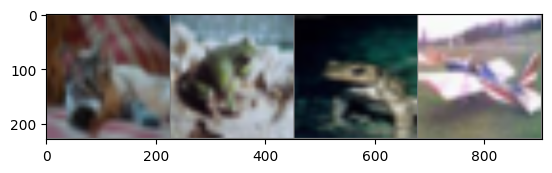

In [6]:
ROOT = "./data"
Model_PATH = "./model/GoogLeNet"
BatchSize = 128
optimizer = optim.SGD
criterion = nn.CrossEntropyLoss()

trains, tests, labels = basic.load_CIFAR10_datasets(BatchSize,224,ROOT)
basic.show_some_samples(trains,labels)

In [7]:
google_net = GoogLeNet()
X = torch.rand(size=(1,3,224,224))
for layer in google_net.net:
    X = layer(X)
    print(layer.__class__.__name__,"output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
google_net.train(trains,criterion,optimizer,epochs=10)
torch.save(google_net.net,Model_PATH)

In [ ]:
google_net = GoogLeNet()
google_net.try_gpu()
google_net.net=torch.load(Model_PATH,map_location=google_net.device)
google_net.accuracy(tests)
google_net.label_accuracy(tests,labels)